# Figure 1 - Using logistic regression to identify the best performing inheritance model. 

## The four inheritance models produced four simulated COVID-19 population datasets. Each of these datasets contains nearly 1 million rows and 2560 columns. I will first downsample the rows labelled as "control" to match the number of "cases" for each model

In [1]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import sklearn.impute
import sklearn.ensemble
import scipy.stats
import matplotlib as mpl
import seaborn as sns
#import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
mpl.rcParams['figure.dpi'] = 250
pd.set_option('display.max_rows', 50)

df = pd.read_csv("covid_gwas_rec-dom_Resampled.csv", sep=",", header=0, index_col=0)
display(df)

,class,rs140604514,rs75811734,rs12127714,rs12139500,rs190204955,rs56270766,rs10922911,rs10801825,rs10801826,...,rs113439507,rs112426803,rs111718325,rs75585764,rs74766371,rs9983330,rs12329760,rs150868259,rs142121339,rs191514675
subject,,,,,,,,,,,,,,,,,,,,,
s1,case,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,1,1,0,0,0
s2,case,0,0,0,0,0,1,0,1,0,...,1,0,1,0,1,1,1,0,0,0
s3,case,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,1,1,0,0,0
s4,case,0,0,0,0,0,1,1,1,1,...,1,0,1,0,1,1,1,0,0,0
s5,case,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s969685,control,0,0,0,0,0,1,1,1,1,...,0,0,0,0,0,1,1,0,0,0
s969686,control,0,0,0,0,0,1,0,1,0,...,1,0,1,0,1,0,1,0,0,0
s969687,control,0,0,0,0,0,1,0,1,0,...,1,0,1,0,1,1,1,0,1,0


## Visualizing the data imbalance between cases vs controls

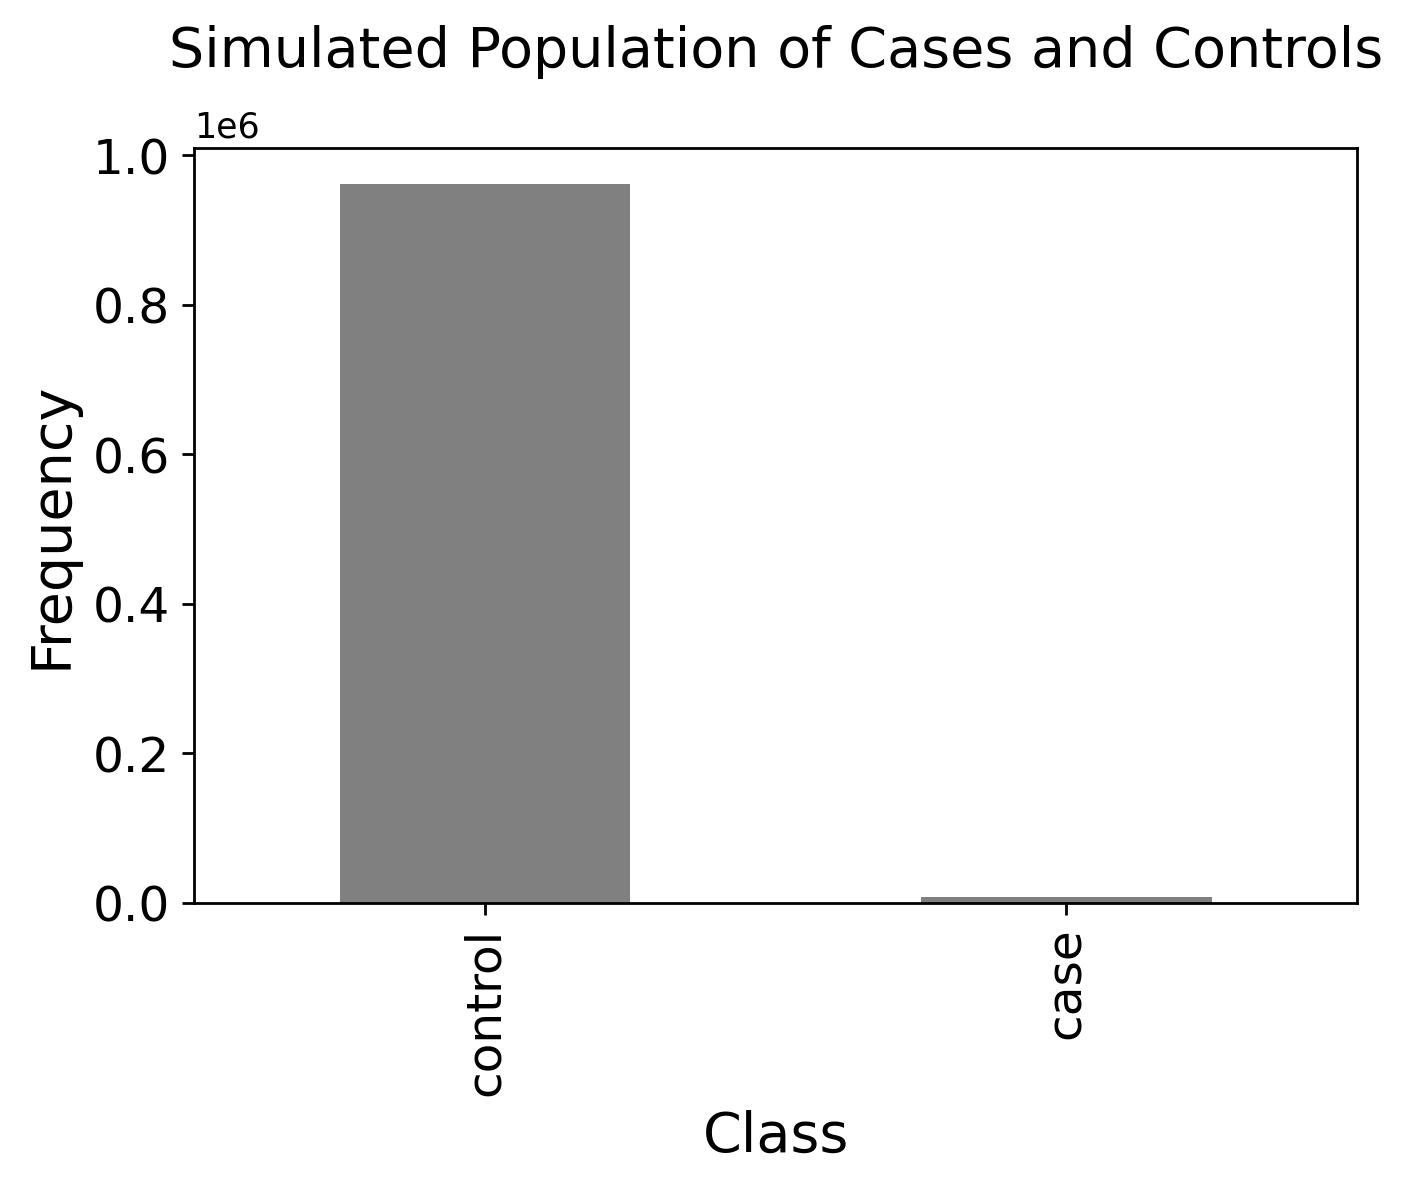

<Figure size 1500x1000 with 0 Axes>

In [34]:
cases_controls = df['class'].value_counts().plot(kind='bar', color = "gray")
cases_controls.set_xlabel("Class", fontsize = 16)
cases_controls.set_ylabel("Frequency", fontsize = 16)
cases_controls.axes.set_title("Simulated Population of Cases and Controls",fontsize=16, y= 1.08)
cases_controls.tick_params(labelsize = 14)
plt.figure()
vis = cases_controls.get_figure()
vis.savefig("Fig1B.pdf", bbox_inches='tight')

## The downsampling is performed five times (without replacement). This is done to ensure that the random downsampling of control individuals doesn't significantly alter the logistic regression performance.

In [20]:
def downsample_logisticreg(filename):
    
    df = pd.read_csv(filename, sep=",", header=0, index_col=0)
    logistic_performance = {"precision": [],"recall" : [], "f1" : [], "accuracy" : [], "AUROC" : []}
    for i in range(5):
        df_sample = pd.DataFrame()
        for patient in df["class"].unique():
            df_patient = df[df["class"] == patient]
            sample_size = 7885
            sample = df_patient.sample(n=sample_size, replace = False) 
            df_sample = df_sample.append(sample)

        X = df_sample.iloc[:,1:]
        Y = df_sample["class"]
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, train_size = 0.8,random_state = 5)

        logistic = LogisticRegression()
        logistic.fit(X_train,Y_train)
        logistic_pred = logistic.predict(X_test)
        logistic_performance["precision"].append(precision_score(Y_test, logistic_pred, average="macro"))
        logistic_performance["recall"].append(recall_score(Y_test, logistic_pred, average="macro"))
        logistic_performance["f1"].append(f1_score(Y_test, logistic_pred, average="macro"))
        logistic_performance["accuracy"].append(accuracy_score(Y_test,logistic_pred))
        logistic_performance["AUROC"].append(roc_auc_score(Y_test,logistic.predict_proba(X_test)[:,1]))
    return [logistic_performance, df_sample]

## The above logistic regression is performed for each inheritance model and the resulting performance is shown as a bar graph.

In [4]:
dominant_performance = downsample_logisticreg(filename = "covid_gwas_dominant_Resampled.csv")[0]
df_dominant = pd.DataFrame(dominant_performance)
df_dominant.to_csv('dominant_performance.csv')

In [5]:
recessive_performance = downsample_logisticreg(filename = "covid_gwas_recessive_Resampled.csv")[0]
df_recessive = pd.DataFrame(recessive_performance)
df_recessive.to_csv('recessive_performance.csv')

In [6]:
rec_dom_performance = downsample_logisticreg(filename = "covid_gwas_rec-dom_Resampled.csv")[0]
df_rec_dom = pd.DataFrame(rec_dom_performance)
df_rec_dom.to_csv('rec_dom_performance.csv')

In [7]:
dom_rec_performance = downsample_logisticreg(filename = "covid_gwas_dom-rec_Resampled.csv")[0]
df_dom_rec = pd.DataFrame(dom_rec_performance)
df_dom_rec.to_csv('dom_rec_performance.csv')

In [9]:
classification_df = pd.DataFrame({"metric": ["Precision","Recall","F1","Accuracy", "AUROC"],"dominant_mean" : [np.mean(v) for k,v in dominant_performance.items()],
                          "dominant_sd" : [np.std(v) for v in dominant_performance.values()],
                          "recessive_mean" : [np.mean(v) for k,v in recessive_performance.items()],
                          "recessive_sd" : [np.std(v) for v in recessive_performance.values()],
                         "domrec_mean" : [np.mean(v) for k,v in dom_rec_performance.items()],
                          "domrec_sd" : [np.std(v) for v in dom_rec_performance.values()],
                         "recdom_mean" : [np.mean(v) for k,v in rec_dom_performance.items()],
                          "recdom_sd" : [np.std(v) for v in rec_dom_performance.values()]})
print(classification_df)

      metric  dominant_mean  dominant_sd  recessive_mean  recessive_sd  \
0  Precision       0.860242     0.014353        0.701446      0.010438   
1     Recall       0.846009     0.006807        0.690672      0.005838   
2         F1       0.844879     0.006267        0.686894      0.006168   
3   Accuracy       0.846417     0.006919        0.691122      0.005899   
4      AUROC       0.944761     0.002731        0.796481      0.007303   

   domrec_mean  domrec_sd  recdom_mean  recdom_sd  
0     0.854492   0.002065     0.855780   0.009327  
1     0.845377   0.003589     0.849620   0.009208  
2     0.844658   0.003870     0.849206   0.009264  
3     0.845720   0.003534     0.849905   0.009206  
4     0.945001   0.002472     0.943522   0.004089  


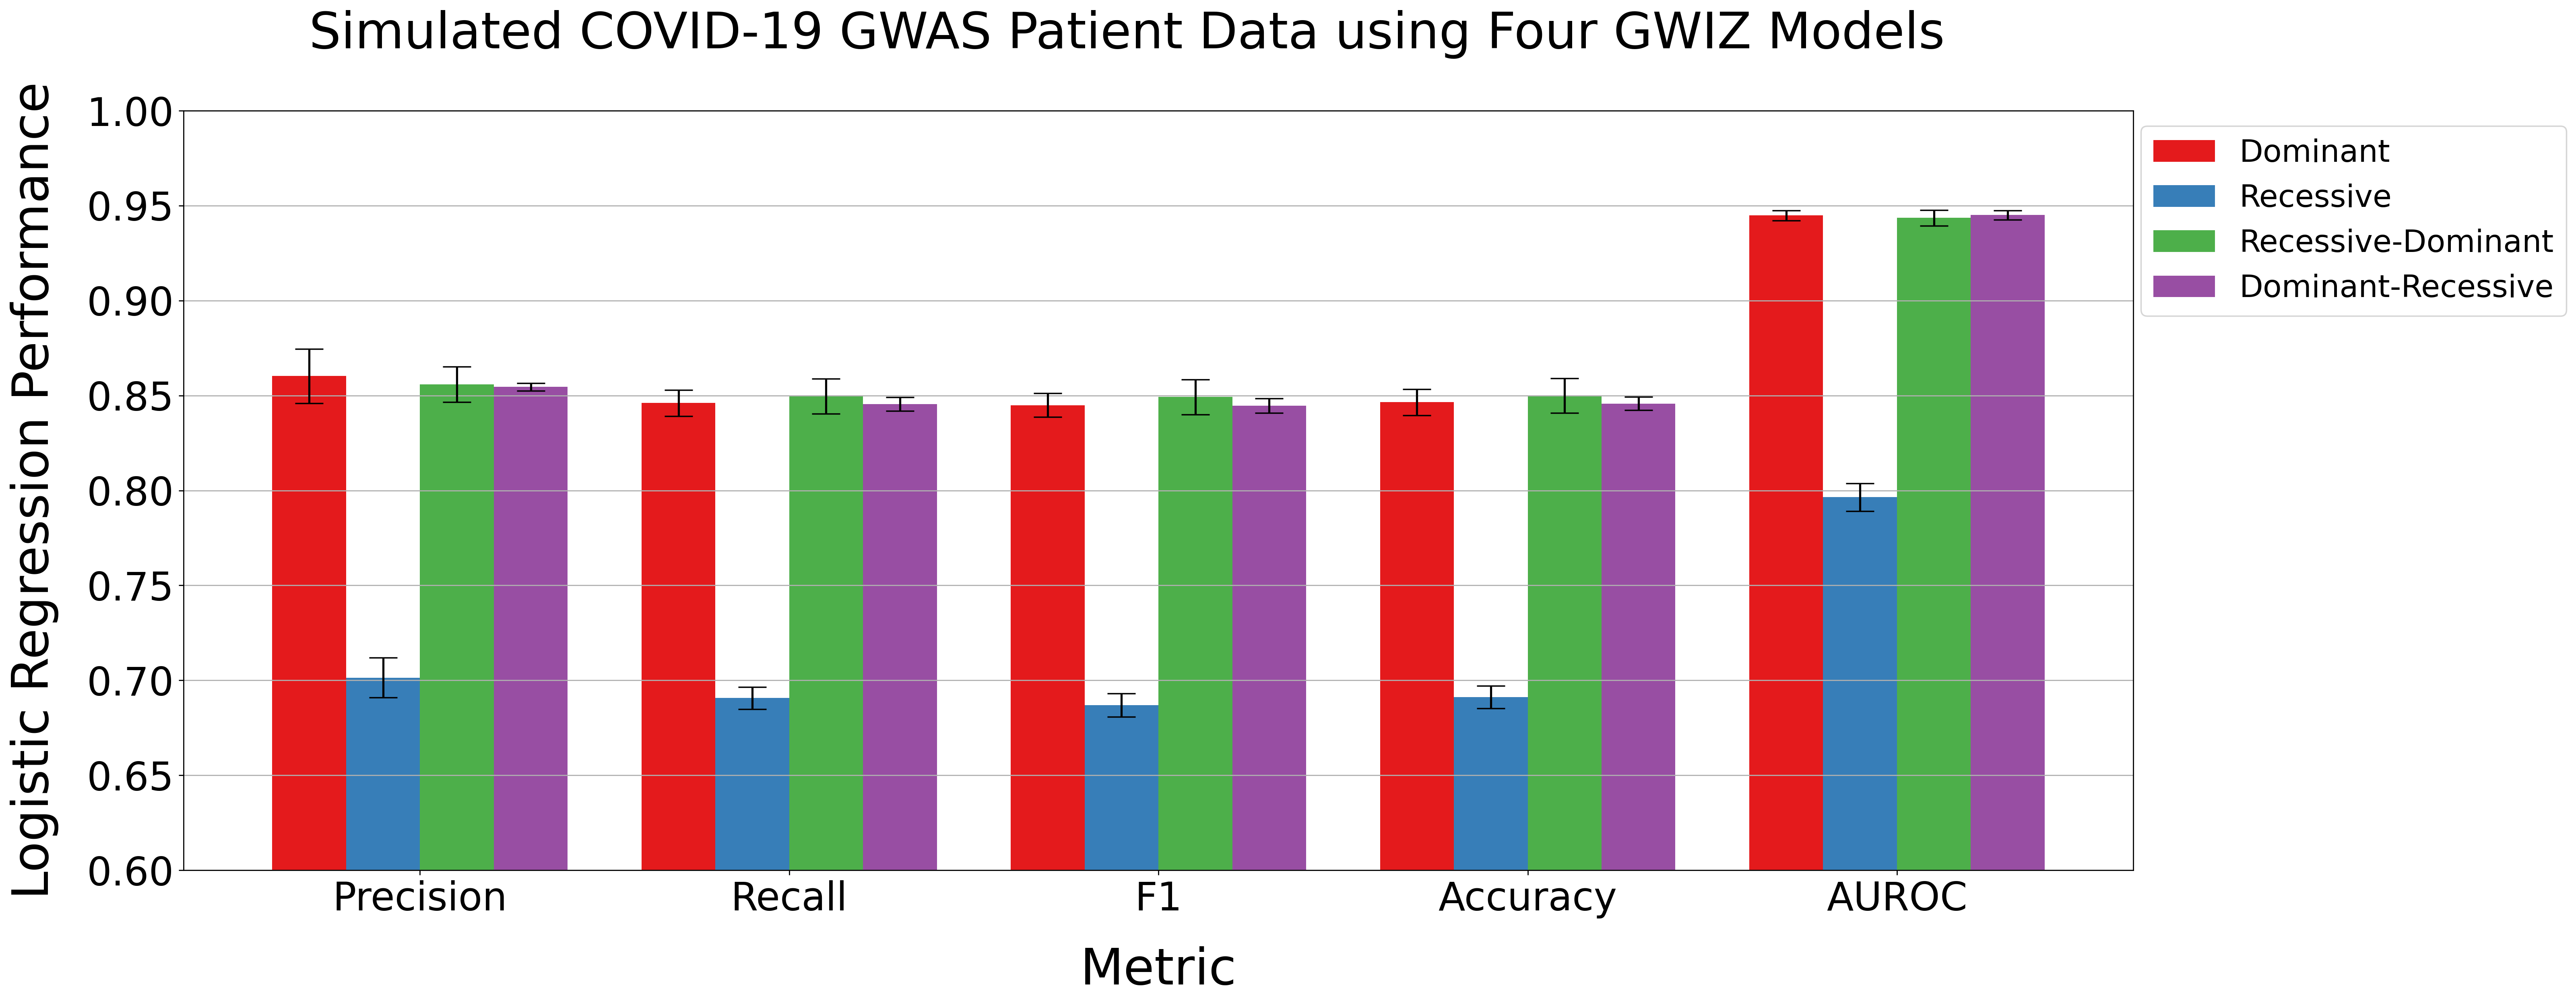

In [15]:
ind = np.arange(5)
fig, ax = plt.subplots(figsize = (25, 10))

dom_bar = ax.bar(ind - 0.3, classification_df.dominant_mean, yerr = classification_df.dominant_sd,alpha=1,width = 0.2,capsize = 10, color = '#e41a1c',align = 'center')
rec_bar = ax.bar(ind - 0.1 , classification_df.recessive_mean,yerr = classification_df.recessive_sd,alpha=1, width = 0.2,capsize = 10, color = '#377eb8', align = 'center')
recdom_bar = ax.bar(ind + 0.1, classification_df.recdom_mean,yerr = classification_df.recdom_sd,alpha=1, width = 0.2,capsize = 10, color = '#4daf4a',align = 'center')
domrec_bar = ax.bar(ind + 0.3, classification_df.domrec_mean,yerr = classification_df.domrec_sd,alpha=1, width = 0.2,capsize = 10, color = '#984ea3', align = 'center')
ax.set_ylabel("Logistic Regression Performance", size = 36)
ax.set_ylim([0.60,1])
ax.set_xlabel("Metric", size = 36)
ax.set_xticks(ind)
ax.set_xticklabels(classification_df.metric,rotation = 0)
ax.tick_params(axis='both', labelsize=28)
ax.legend((dom_bar[0], rec_bar[0],recdom_bar[0],domrec_bar[0]), ('Dominant','Recessive','Recessive-Dominant', 'Dominant-Recessive'),prop={'size': 22}, bbox_to_anchor=(1.23, 1), loc='upper right')
ax.yaxis.grid(True)
fig.suptitle('Classification of COVID-19 Cases vs Controls Generated with Four Inheritance Models', fontsize=36)
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
vis = ax.get_figure()
vis.savefig("Fig1A.pdf", bbox_inches='tight')

In [21]:
bestmodel_df = downsample_logisticreg(filename = "covid_gwas_rec-dom_Resampled.csv")[1]
bestmodel_df

,class,rs140604514,rs75811734,rs12127714,rs12139500,rs190204955,rs56270766,rs10922911,rs10801825,rs10801826,...,rs113439507,rs112426803,rs111718325,rs75585764,rs74766371,rs9983330,rs12329760,rs150868259,rs142121339,rs191514675
subject,,,,,,,,,,,,,,,,,,,,,
s3787,case,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
s1411,case,0,0,0,0,0,1,0,1,0,...,1,0,1,0,1,0,1,0,0,0
s5344,case,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
s2724,case,0,0,0,0,0,1,0,1,0,...,1,0,1,0,1,0,1,0,0,0
s4299,case,0,0,0,0,0,1,1,1,1,...,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s677626,control,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,1,1,0,0,0
s330941,control,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
s754782,control,0,0,0,0,0,1,1,1,1,...,0,0,0,0,0,1,1,0,0,0


## Visualizing the downsampled controls vs cases

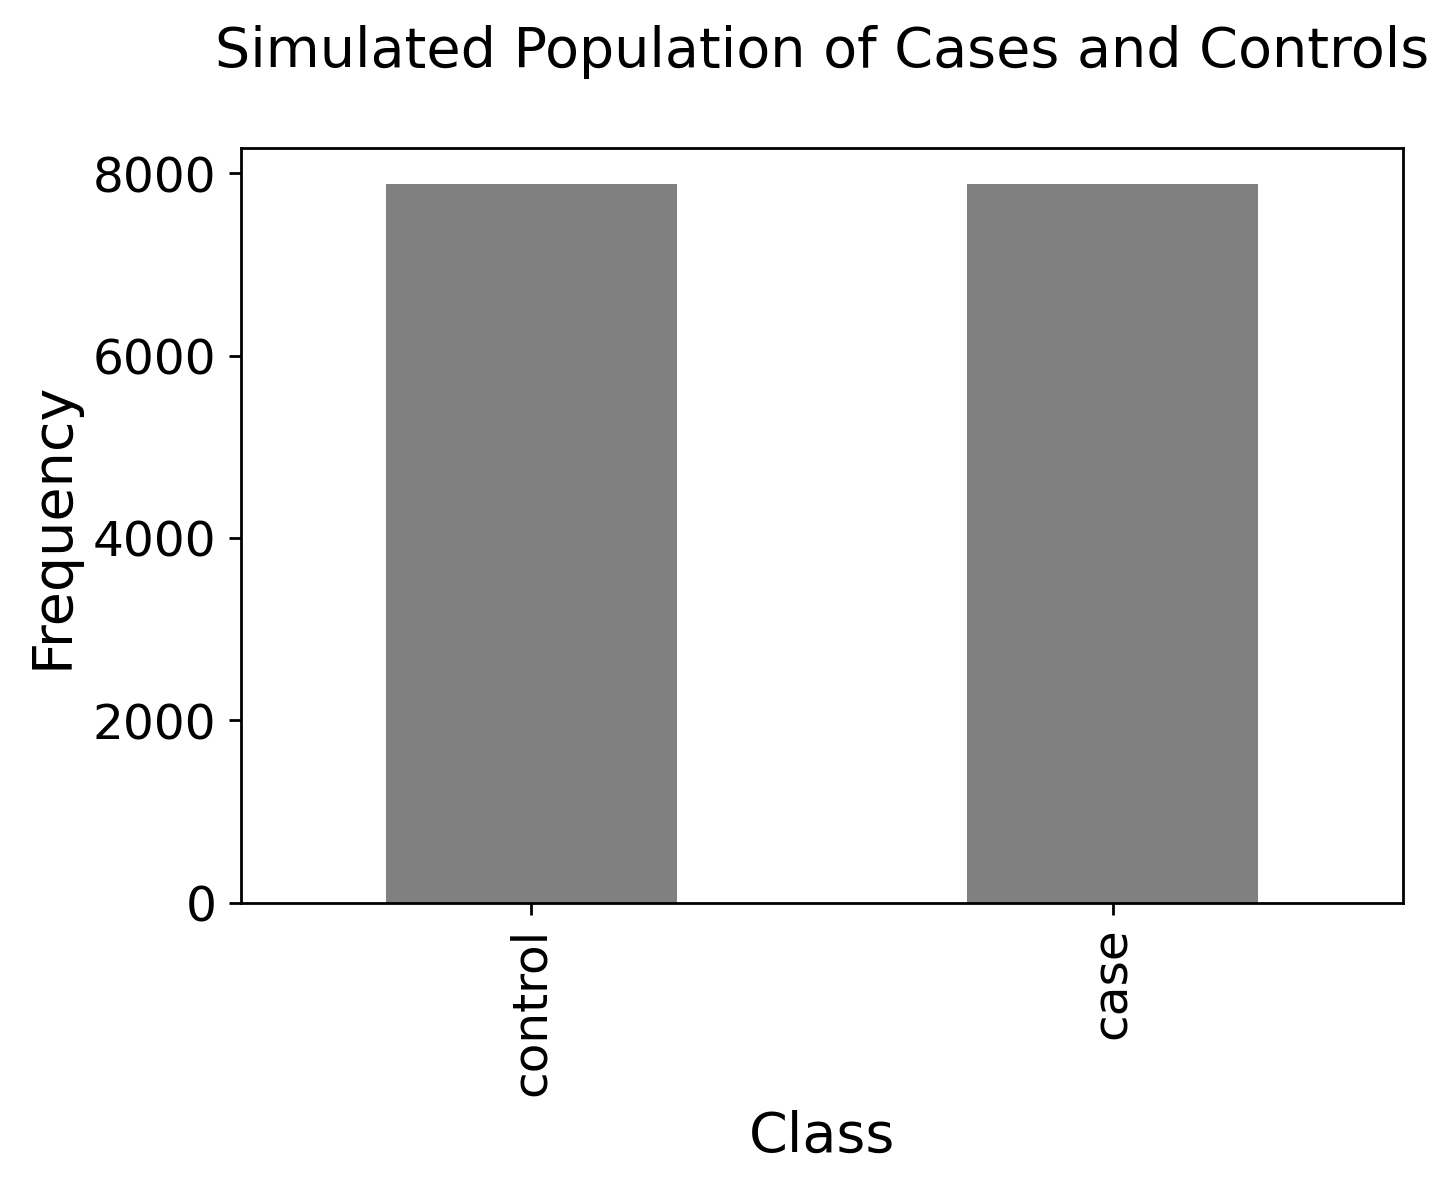

<Figure size 1500x1000 with 0 Axes>

In [35]:
controlvcase = bestmodel_df['class'].value_counts().plot(kind='bar', color = "gray")
controlvcase.set_xlabel("Class", fontsize = 16)
controlvcase.set_ylabel("Frequency", fontsize = 16)
controlvcase.axes.set_title("Simulated Population of Cases and Controls",fontsize=16, y= 1.08)
controlvcase.tick_params(labelsize = 14)
plt.figure()
vis = controlvcase.get_figure()
vis.savefig("Fig1C.pdf", bbox_inches='tight')
bestmodel_df.to_csv('COVID19_GWAS_downsampled_population.csv')